# HR데이터를 활용한 직원 이탈 요인 분석
- Data Link : https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset

> 분석 프로세스 수립
>> 데이터 수집
- 데이터 : HR 데이터
- 분석 목표 정의 : HR 데이터를 활용한 주요 직원 이탈 요인 분석

>> 데이터 탐색 전처리
- 결측값, 중복값 여부
- Target Feature 생성
- 불필요한 Feature 제거
- 범주형 Feature 인코딩
- Feature 간 상관성 분석

>> 데이터 정제
- 불균형 Target Feautre 오버샘플링

>> 모델 생성
- GridSearchCV 활용 최적 하이퍼 파라미터 탐색
- Random Forest
- Gradient Boosting

>> 모델 평가
- 정밀도
- 재현율
- F1-Score
- Feature Importance

>> 의사 결정

> 컬럼 정보
- 1. Age : 나이
- 2. Attrition : 퇴직 여부(Yes/No)
- 3. Business Travel : 출장 빈도
- 4. DaliyRate : 일일 급여 수준
- 5. Department : 소속 부서
- 6. DistanceFromHome : 출퇴근 거리
- 7. Education : 교육 수준
- 8. EducationField : 전공
- 9. EmployeeCount : 직원숫자
- 10. EmployeeNumber : 직원 ID
- 11. EnvironmentSatisfaction : 업무 만족도
- 12. Gender : 성별
- 13. HourlyRate : 시급 수준
- 14. Joblnvolvement : 업무 참여도
- 15. JobLevel : 업무 수준
- 16. JobRole : 업무 유형
- 17. JobSatisfaction : 업무 만족도
- 18. MaritalStatus : 결혼 여부
- 19. MonthlyIncome : 월 소득
- 20. MonthlyRate : 월급 수준
- 21. NumCompaniesWorked : 일한 회사의 수
- 22. Over18 : 18세 이상
- 23. OverTime : 규정 외 노동시간
- 24. PercentSalaryHike : 임금 상승률
- 25. PerformanceRating : 업무 평가 수준
- 26. Realationship Satisfaction : 대인관계 만족도
- 27. StandardHours : 표준 시간
- 28. StockOptionLevel : 스톡옵션 수준
- 29. TotalWorkingYears : 경력 기간
- 30. TrainingTimesLastYear : 교육 시간
- 31. WorkLifeBalance : 일과 생활의 균형
- 32. YearsAtCompany : 근속 연수
- 33. YearsInCurrentRole : 현재 업무 근로 기간
- 34. YearsSinceLastPromotion : 마지막 프로모션 지급 연도
- 35. YearsWithCurrManager : 현재 관리자와의 협업 기간

## 0. 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, classification_report)
from imblearn.over_sampling import SMOTE

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

plt.rc("font", family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_csv('../02. Data/[Ch02]WA_Fn-UseC_-HR-Employee-Attrition.csv')

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## 1. 데이터 탐색

### 1.1 변수 간 관계 시각화(KDE Plot)

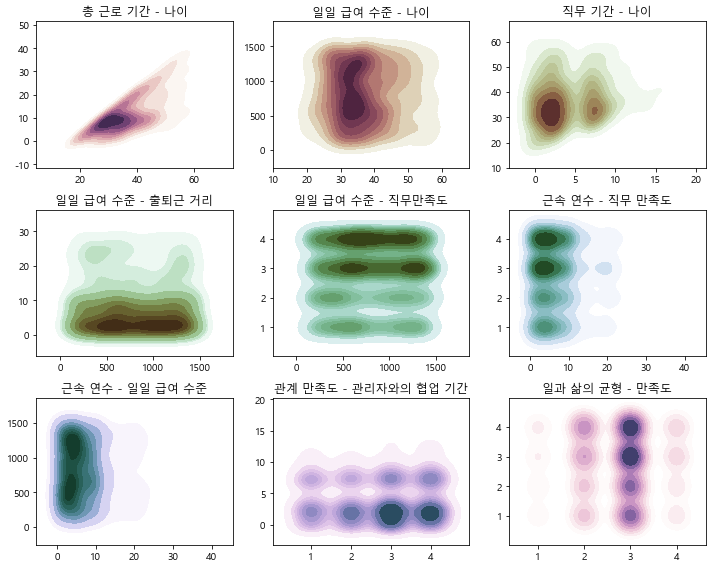

In [3]:
# 여러 개의 KDE Plot 생성 준비
f, axes = plt.subplots(3, 3, figsize=(10, 8), 
                       sharex=False, sharey=False)

# Plot 색상 설정
s = np.linspace(0, 3, 10)

# 총 근로기간-나이
cmap = sns.cubehelix_palette(start=0.0, light=1, as_cmap=True)
x = df['Age'].values
y = df['TotalWorkingYears'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=axes[0,0])
axes[0,0].set(title = '총 근로 기간 - 나이')

# 일일 급여수준 - 나이
cmap = sns.cubehelix_palette(start=0.333333333333, light=1, as_cmap=True)
x = df['Age'].values
y = df['DailyRate'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[0,1])
axes[0,1].set(title = '일일 급여 수준 - 나이')

# 직무 기간 - 나이
cmap = sns.cubehelix_palette(start=0.666666666667, light=1, as_cmap=True)
x = df['YearsInCurrentRole'].values
y = df['Age'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[0,2])
axes[0,2].set(title = '직무 기간 - 나이')

# 일일 급여수준 - 출퇴근 거리
cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)
x = df['DailyRate'].values
y = df['DistanceFromHome'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,0])
axes[1,0].set(title = '일일 급여 수준 - 출퇴근 거리')

# 일일급여수준 - 직무만족도
cmap = sns.cubehelix_palette(start=1.333333333333, light=1, as_cmap=True)
x = df['DailyRate'].values
y = df['JobSatisfaction'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,1])
axes[1,1].set(title = '일일 급여 수준 - 직무만족도')

# 근속연수 - 직무만족도
cmap = sns.cubehelix_palette(start=1.666666666667, light=1, as_cmap=True)
x = df['YearsAtCompany'].values
y = df['JobSatisfaction'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,2])
axes[1,2].set(title = '근속 연수 - 직무 만족도')

# 근속연수 - 일일급여수준
cmap = sns.cubehelix_palette(start=2.0, light=1, as_cmap=True)
x = df['YearsAtCompany'].values
y = df['DailyRate'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[2,0])
axes[2,0].set(title = '근속 연수 - 일일 급여 수준')

# 관계 만족도 - 관리자와의 협업기간
cmap = sns.cubehelix_palette(start=2.333333333333, light=1, as_cmap=True)
x = df['RelationshipSatisfaction'].values
y = df['YearsWithCurrManager'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[2,1])
axes[2,1].set(title = '관계 만족도 - 관리자와의 협업 기간')

# 일과삶의 균형 - 만족도
cmap = sns.cubehelix_palette(start=2.666666666667, light=1, as_cmap=True)
x = df['WorkLifeBalance'].values
y = df['JobSatisfaction'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[2,2])
axes[2,2].set(title = '일과 삶의 균형 - 만족도')

f.tight_layout()

## 2. 데이터 전처리

### 2.1 결측값 처리

In [4]:
# 컬럼별 결측값 확인
display(df.isnull().any())

Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL

### 2.2 중복값 처리

In [5]:
print("중복된 항목 수 :", len(df[df.duplicated()])) 

중복된 항목 수 : 0


## 3. Target Feature 정의
- Attrition 컬럼 : Yes일 경우 1, No일 경우 0

In [6]:
df["Attrition"].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

In [7]:
target_map = {'Yes':1, 'No':0}
df["Attrition_numerical"] = df["Attrition"].apply(lambda x: target_map[x])

df["Attrition_numerical"].value_counts()

0    1233
1     237
Name: Attrition_numerical, dtype: int64

In [8]:
# 기존 Target Feauture 제거
df.drop(['Attrition'], axis=1, inplace=True)
df.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition_numerical'],
      dtype='object')

## 4. Feature 변환

### 4.1 Feature 타입별 개수 확인

In [9]:
# Feauture 개수 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   BusinessTravel            1470 non-null   object
 2   DailyRate                 1470 non-null   int64 
 3   Department                1470 non-null   object
 4   DistanceFromHome          1470 non-null   int64 
 5   Education                 1470 non-null   int64 
 6   EducationField            1470 non-null   object
 7   EmployeeCount             1470 non-null   int64 
 8   EmployeeNumber            1470 non-null   int64 
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   int64 
 14  JobRole                 

In [10]:
# 데이터 타입별 컬럼 수 확인
dtype_data = df.dtypes.reset_index()
dtype_data.columns = ["Count", "Column Type"]
dtype_data = dtype_data.groupby("Column Type").aggregate('count').reset_index()

print(dtype_data)

  Column Type  Count
0       int64     27
1      object      8


### 4.2 범주형 Feature
- 범주형 데이터 확인
- 불필요 컬럼 제거
- Feature 별 개수 시각화
- 변환 항목 여부

#### 4,2.1 범주형 데이터 확인

In [11]:
df.select_dtypes(include=['object','category']).head()

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes
1,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,Y,No
2,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,Yes
3,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Y,Yes
4,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No


#### 4.2.2 불필요 컬럼 제거

In [12]:
# 유일값 개수 확인
cat_feat = df.select_dtypes('object','category').columns.values
df_cat = df[cat_feat].copy()

print(df_cat.nunique().sort_values())

Over18            1
Gender            2
OverTime          2
BusinessTravel    3
Department        3
MaritalStatus     3
EducationField    6
JobRole           9
dtype: int64


In [13]:
# 유일값 1개인 컬럼 제거
df_cat = df_cat.drop(['Over18'], axis=1)
df_cat.columns

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime'],
      dtype='object')

#### 4.2.3 Feature 별 개수 시각화

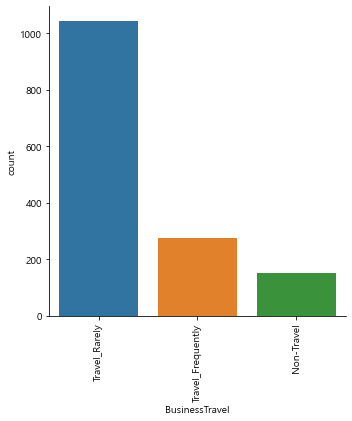

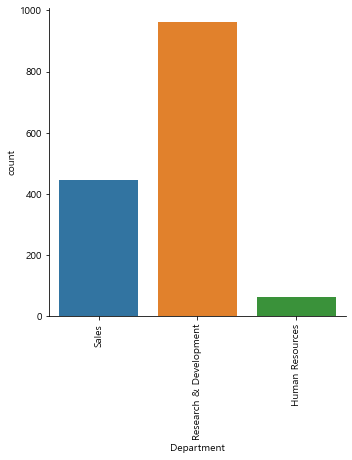

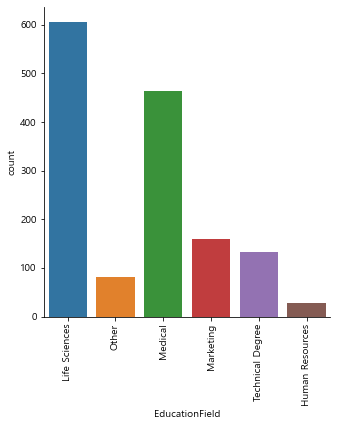

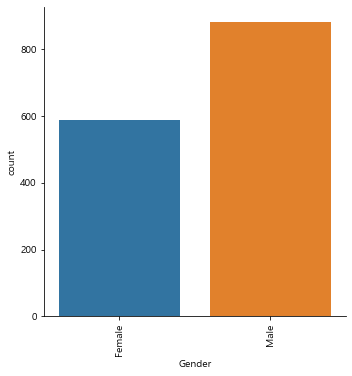

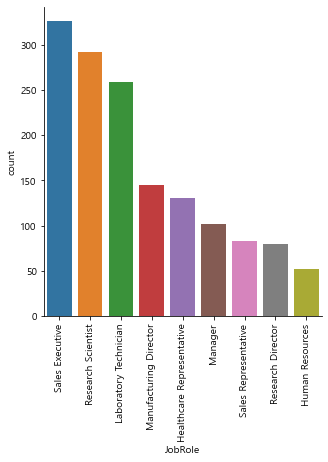

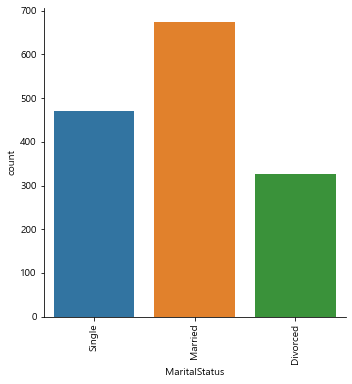

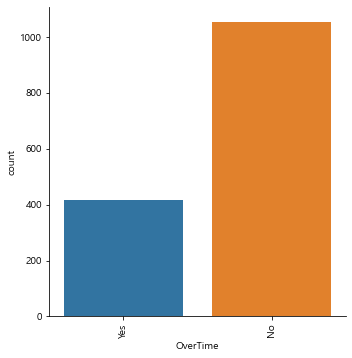

In [14]:
for col in df_cat.columns:
    fig = sns.catplot(x=col, kind="count", data=df_cat, hue=None)
    fig.set_xticklabels(rotation=90)
    plt.show()

#### 4.2.4 인코딩
- LabelEncoder
    - 숫자의 특성 때문에 가중치의 차이가 생김, 더 큰숫자로 인코딩되는 문자의 중요도가 높아짐
    - 선형성 가지는 머신러닝 기법에 안쓰는것이 좋음
- OneHotEncoder
    - LabelEncoder으로 할당된 숫자를 각 열을 추가해서 0또는 1로 나타냄
    - LabelEncoder의 단점을 해결하여 숫자의 크고 작은 특성(중요도)를 없앰
    - 단점은 LabelEncoder이 선행되어야 하고, 입력값으로 2차원 데이터 필요
- get_dummies
    - LabelEncoder + OneHotEncoder

In [15]:
df_cat_dummies = pd.get_dummies(df_cat)
df_cat_dummies.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
4,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


#### 4.2.5 상관성 분석

In [16]:
from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
    crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # 교차 테이블
    stat = chi2_contingency(crosstab)[0] # 카이제곱 검정 통계량
    obs = np.sum(crosstab) # 관측치 수
    mini = min(crosstab.shape)-1 # 교차 테이블의 행과열 최솟값
    return (stat / (obs*mini))

In [17]:
rows= []

for var1 in df_cat_dummies:
    col = []
    for var2 in df_cat_dummies :
        cramers =cramers_V(df_cat_dummies[var1], df_cat_dummies[var2]) # 크래머 v 테스트
        col.append(round(cramers,2)) # 크래서 v 테스트 값 반올림
    rows.append(col)

cramers_results = np.array(rows)

df_cat_dummies_corr = pd.DataFrame(cramers_results, columns = df_cat_dummies.columns, index =df_cat_dummies.columns)
df_cat_dummies_corr.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
BusinessTravel_Non-Travel,0.99,0.03,0.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
BusinessTravel_Travel_Frequently,0.03,1.00,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
BusinessTravel_Travel_Rarely,0.27,0.56,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
Department_Human Resources,0.00,0.00,0.00,0.98,0.08,0.02,0.40,0.00,0.00,0.00,...,0.00,0.00,0.01,0.01,0.00,0.0,0.0,0.0,0.0,0.0
Department_Research & Development,0.00,0.00,0.00,0.08,1.00,0.82,0.03,0.02,0.23,0.03,...,0.06,0.03,0.13,0.54,0.11,0.0,0.0,0.0,0.0,0.0


In [18]:
np.sum(df_cat_dummies_corr > 0.9)

BusinessTravel_Non-Travel            1
BusinessTravel_Travel_Frequently     1
BusinessTravel_Travel_Rarely         1
Department_Human Resources           1
Department_Research & Development    1
Department_Sales                     1
EducationField_Human Resources       1
EducationField_Life Sciences         1
EducationField_Marketing             1
EducationField_Medical               1
EducationField_Other                 1
EducationField_Technical Degree      1
Gender_Female                        2
Gender_Male                          2
JobRole_Healthcare Representative    1
JobRole_Human Resources              1
JobRole_Laboratory Technician        1
JobRole_Manager                      1
JobRole_Manufacturing Director       1
JobRole_Research Director            1
JobRole_Research Scientist           1
JobRole_Sales Executive              1
JobRole_Sales Representative         1
MaritalStatus_Divorced               1
MaritalStatus_Married                1
MaritalStatus_Single     

### 4.3 숫자형 Feature

#### 4.3.1 숫자형 데이터 확인

In [19]:
df.select_dtypes(include=['number']).head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_numerical
0,41,1102,1,2,1,1,2,94,3,2,...,80,0,8,0,1,6,4,0,5,1
1,49,279,8,1,1,2,3,61,2,2,...,80,1,10,3,3,10,7,1,7,0
2,37,1373,2,2,1,4,4,92,2,1,...,80,0,7,3,3,0,0,0,0,1
3,33,1392,3,4,1,5,4,56,3,1,...,80,0,8,3,3,8,7,3,0,0
4,27,591,2,1,1,7,1,40,3,1,...,80,1,6,3,3,2,2,2,2,0


In [20]:
num_feat = df.select_dtypes('number').columns.values
df_num = df[num_feat].copy()

df_num

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_numerical
0,41,1102,1,2,1,1,2,94,3,2,...,80,0,8,0,1,6,4,0,5,1
1,49,279,8,1,1,2,3,61,2,2,...,80,1,10,3,3,10,7,1,7,0
2,37,1373,2,2,1,4,4,92,2,1,...,80,0,7,3,3,0,0,0,0,1
3,33,1392,3,4,1,5,4,56,3,1,...,80,0,8,3,3,8,7,3,0,0
4,27,591,2,1,1,7,1,40,3,1,...,80,1,6,3,3,2,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,1,2061,3,41,4,2,...,80,1,17,3,3,5,2,0,3,0
1466,39,613,6,1,1,2062,4,42,2,3,...,80,1,9,5,3,7,7,1,7,0
1467,27,155,4,3,1,2064,2,87,4,2,...,80,1,6,0,3,6,2,0,3,0
1468,49,1023,2,3,1,2065,4,63,2,2,...,80,0,17,3,2,9,6,0,8,0


#### 4.3.2 불필요 컬럼 제거

In [21]:
df_num.nunique().sort_values()

EmployeeCount                  1
StandardHours                  1
Attrition_numerical            2
PerformanceRating              2
WorkLifeBalance                4
StockOptionLevel               4
EnvironmentSatisfaction        4
JobInvolvement                 4
JobSatisfaction                4
RelationshipSatisfaction       4
Education                      5
JobLevel                       5
TrainingTimesLastYear          7
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                37
TotalWorkingYears             40
Age                           43
HourlyRate                    71
DailyRate                    886
MonthlyIncome               1349
MonthlyRate                 1427
EmployeeNumber              1470
dtype: int64

In [22]:
df.shape

(1470, 35)

In [23]:
# 유일값 1개이거나, 모든 행의 값이 다른 컬럼 제거
df_num.drop(['EmployeeCount', 'StandardHours', 'EmployeeNumber'], axis=1, inplace=True)
df_num.nunique().sort_values()

Attrition_numerical            2
PerformanceRating              2
WorkLifeBalance                4
EnvironmentSatisfaction        4
StockOptionLevel               4
JobInvolvement                 4
JobSatisfaction                4
RelationshipSatisfaction       4
Education                      5
JobLevel                       5
TrainingTimesLastYear          7
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                37
TotalWorkingYears             40
Age                           43
HourlyRate                    71
DailyRate                    886
MonthlyIncome               1349
MonthlyRate                 1427
dtype: int64

#### 4.3.3 Feature 별 개수 시각화
- Feature Skewness(변수 비대칭성)

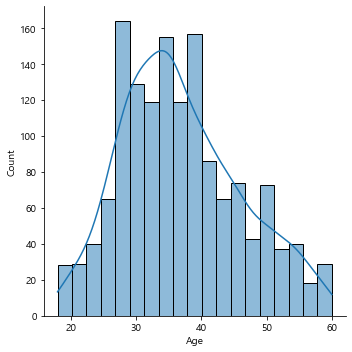

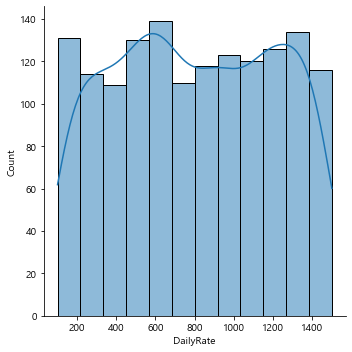

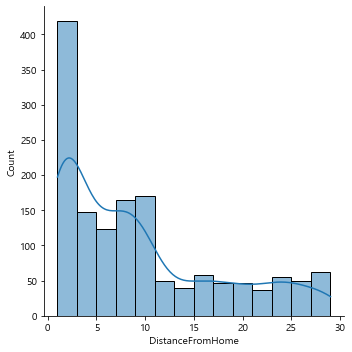

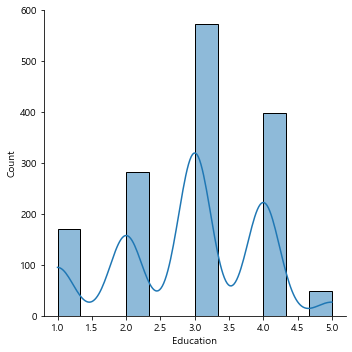

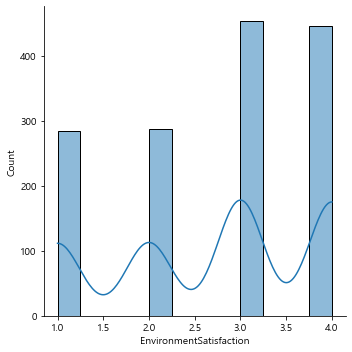

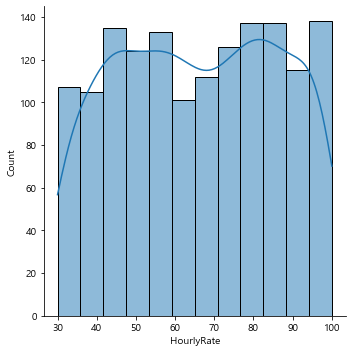

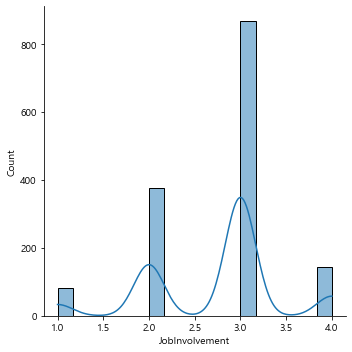

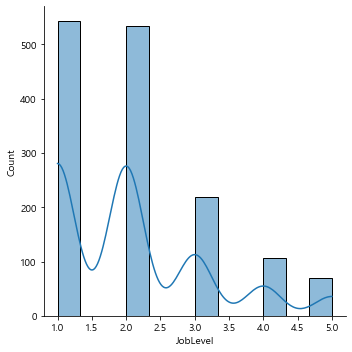

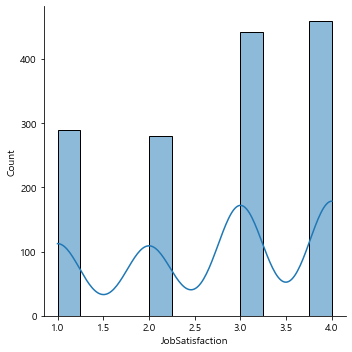

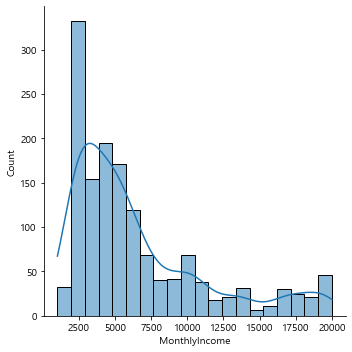

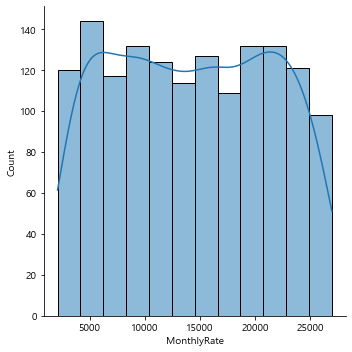

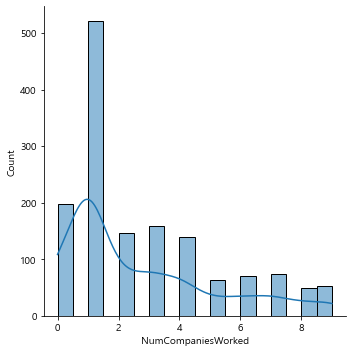

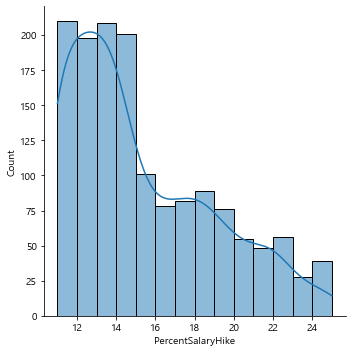

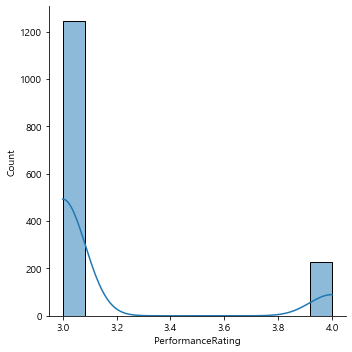

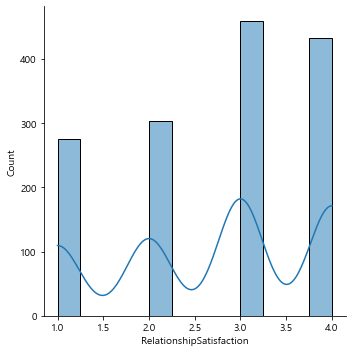

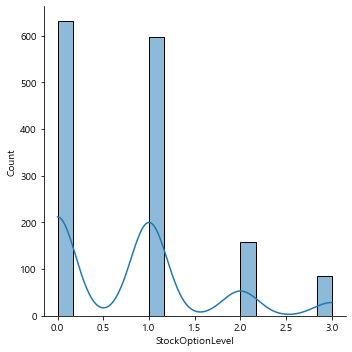

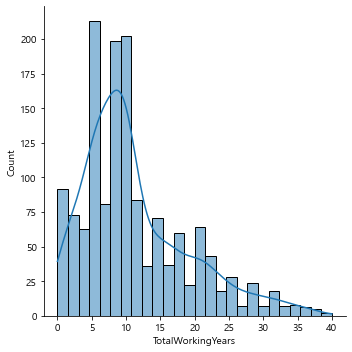

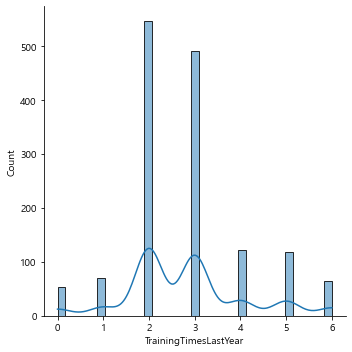

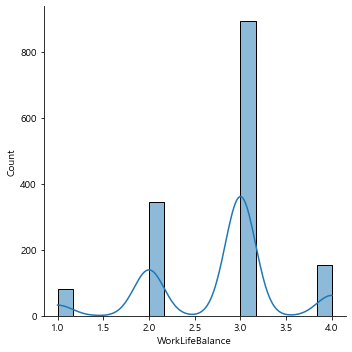

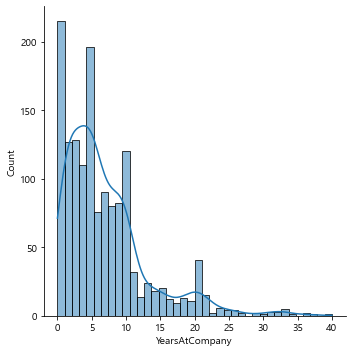

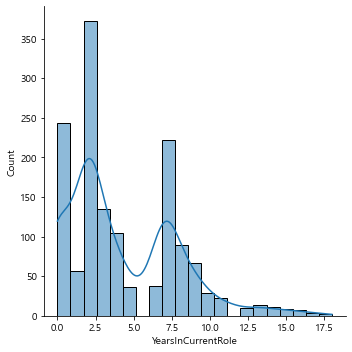

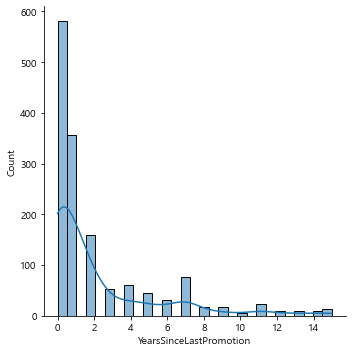

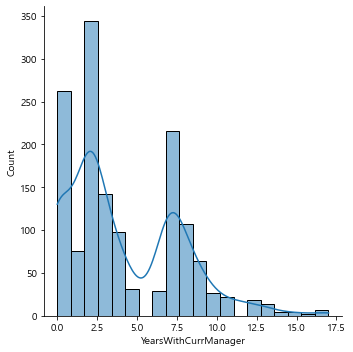

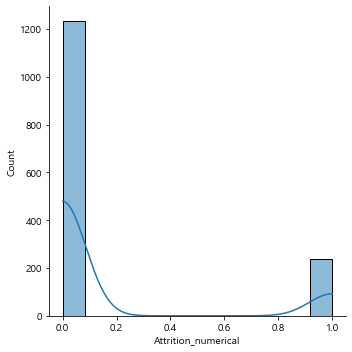

In [24]:
col_df_num = df_num.columns.values

for i in range(0,len(col_df_num)):
    sns.displot(df_num[col_df_num[i]],kde=True)

#### 4.3.4 상관성 분석

In [25]:
num_feat = df_num.columns.values

comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])

for comb in comb_num_feat:
    corr = pearsonr(df_num[comb[0]], df_num[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)
    
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num    

array([['JobLevel', 'MonthlyIncome']], dtype='<U24')

In [26]:
# 2개 컬럼중 첫번째 컬럼
high_corr_num[:, 0]

array(['JobLevel'], dtype='<U24')

In [27]:
# 첫번째 컬럼 제거
df_num = df_num.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')
df_num.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Attrition_numerical'],
      dtype='object')

#### 4.3.5 데이터 결합

In [28]:
print('숫자형 데이터프레임', df_num.shape)
print('범주형 데이터프레임', df_cat_dummies.shape)

숫자형 데이터프레임 (1470, 23)
범주형 데이터프레임 (1470, 28)


In [29]:
df_final = pd.concat([df_num, df_cat_dummies], axis=1)
df_final.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,4,5993,19479,...,0,0,0,1,0,0,0,1,0,1
1,49,279,8,1,3,61,2,2,5130,24907,...,0,0,1,0,0,0,1,0,1,0
2,37,1373,2,2,4,92,2,3,2090,2396,...,0,0,0,0,0,0,0,1,0,1
3,33,1392,3,4,4,56,3,3,2909,23159,...,0,0,1,0,0,0,1,0,0,1
4,27,591,2,1,1,40,3,2,3468,16632,...,0,0,0,0,0,0,1,0,1,0


## 5. Tareget Feature 불균형 해결

### 5.1 불균형 데이터 확인

<AxesSubplot:xlabel='Attrition_numerical', ylabel='count'>

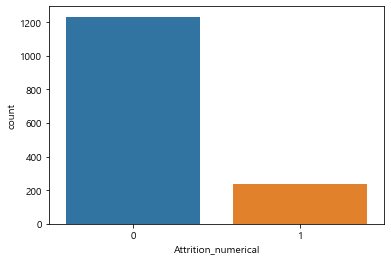

In [30]:
sns.countplot(data=df_final, x='Attrition_numerical')

#### 5.2 SMOTE를 이용한 오버샘플링 적용
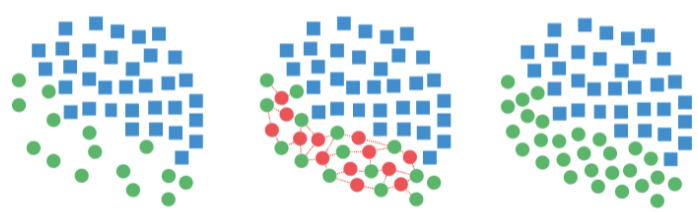

In [31]:
label = 'Attrition_numerical'
X = df_final.drop(label, axis=1)
y = df_final[label]

print('feature', X.shape)
print('target', y.shape)
print(y.value_counts())

feature (1470, 50)
target (1470,)
0    1233
1     237
Name: Attrition_numerical, dtype: int64


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=156)

oversample = SMOTE(random_state=156)
smote_train, smote_target = oversample.fit_resample(X_train, y_train)

smote_train.shape, smote_target.shape, smote_target.value_counts()

print('feature', smote_train.shape)
print('target', smote_target.shape)
print(smote_target.value_counts())

feature (1972, 50)
target (1972,)
1    986
0    986
Name: Attrition_numerical, dtype: int64


## 6. ML Modeling

### 6.1 RandomForest

#### 6.1.1 GridSearchCV를 이용한 최적 Hyper Praameter 탐색

In [33]:
rf_params = { 'n_estimators' : [10, 100],
           'max_depth' : [4, 8, 10, 12],
           'min_samples_leaf' : [2, 4, 8, 12],
           'max_features' : [0.1, 0.3, 0.5]
            }

# RandomForest Classifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 156, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = rf_params, cv = 3, n_jobs = -1)
grid_cv.fit(smote_train, smote_target)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 12, 'max_features': 0.1, 'min_samples_leaf': 2, 'n_estimators': 100}
최고 예측 정확도: 0.9194


In [34]:
# 최적 하이퍼 파라미터 설정
rf_params = {
    'n_jobs': -1,
    'n_estimators': 100, 
    'max_features': 0.1,
    'max_depth': 12,
    'min_samples_leaf': 2,
    'random_state' : 156,
    'verbose': 0
}

#### 6.1.2 모델 성능 평가

In [35]:
# 최적 하이퍼 파라미터 적용
rf = RandomForestClassifier(**rf_params)

rf.fit(smote_train, smote_target)
rf_predictions = rf.predict(X_test)

print("Accuracy score: {}".format(accuracy_score(y_test, rf_predictions)))
print("="*60)
print(classification_report(y_test, rf_predictions))

Accuracy score: 0.8707482993197279
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       247
           1       0.66      0.40      0.50        47

    accuracy                           0.87       294
   macro avg       0.77      0.68      0.71       294
weighted avg       0.86      0.87      0.86       294



#### 6.1.3 Feature Importance
- 상위 20개 피처

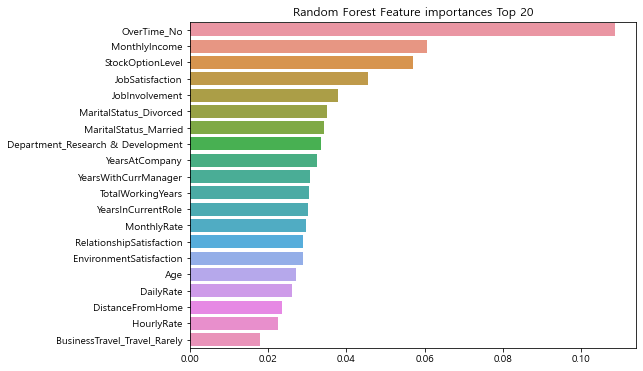

In [36]:
ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Random Forest Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

### 6.2 Gradient Boosting

#### 6.2.1 GridSearchCV를 이용한 최적 Hyper Praameter 탐색

In [37]:
gb_params = { 'n_estimators' : [1000, 1500],
           'max_depth' : [4, 6],
           'min_samples_leaf' : [2, 4],
           'max_features' : [0.7, 0.9],
           'learning_rate' : [0.25,0.3]
            }

# RandomForest Classifier 객체 생성 후 GridSearchCV 수행
gb_clf = GradientBoostingClassifier(random_state = 156)
grid_cv = GridSearchCV(gb_clf, param_grid = gb_params, cv = 3, n_jobs = -1)
grid_cv.fit(smote_train, smote_target)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'learning_rate': 0.25, 'max_depth': 6, 'max_features': 0.9, 'min_samples_leaf': 2, 'n_estimators': 1000}
최고 예측 정확도: 0.9068


In [38]:
# 최적 하이퍼 파라미터 설정
gb_params ={
    'n_estimators': 1000,
    'max_features': 0.9,
    'learning_rate' : 0.25,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'random_state' : 156,
    'verbose': 0
}

#### 6.2.2 모델 성능 평가

In [39]:
gb = GradientBoostingClassifier(**gb_params)

gb.fit(smote_train, smote_target)
gb_predictions = gb.predict(X_test)

print("Accuracy score: {}".format(accuracy_score(y_test, gb_predictions)))
print("="*60)
print(classification_report(y_test, gb_predictions))

Accuracy score: 0.8639455782312925
              precision    recall  f1-score   support

           0       0.87      0.99      0.92       247
           1       0.77      0.21      0.33        47

    accuracy                           0.86       294
   macro avg       0.82      0.60      0.63       294
weighted avg       0.85      0.86      0.83       294



#### 6.2.3 Feature Importance

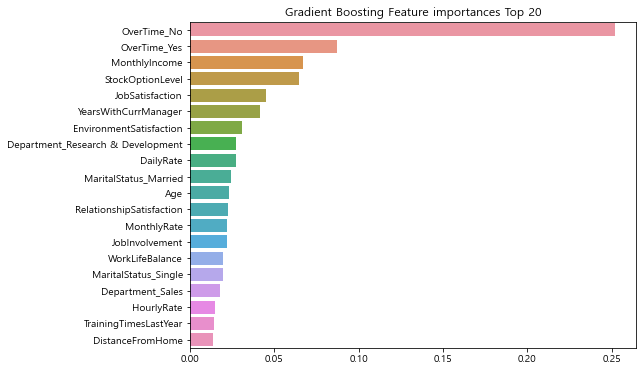

In [40]:
ftr_importances_values = gb.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Gradient Boosting Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()